# MNIST Dataset

## Introduction

We've now talked about why we need machine learning (some relationships are too complex to represent manually), we've looked at the different components of machine learning (model, parameters, loss functions, optimizers), implementing machine learning in a small scale application (linear regression with stochastic gradient descent), and how PyTorch gives us the tools to have more power over our machine learning. Now we are going to combine all of those ideas together to write a model which will identify hand written numbers for us.

### The Dataset

The MNIST dataset is a curated set of hand written numbers that is commonly used as a starting point for machine learning. The original dataset created by NIST (National Institute for Standards and Technology) was leveraged in various goverment tasks related to OCR (Optical Character Recognition). Think tasks like reading tax forms, postal addresses, other manual entry processes. MNIST is a subset of the dataset selected to be more ideal for machine learning with a more sophisticated test/training split. The dataset includes 60,000 images in the training set and 10,000 images in the test set.

### CNNs

Convolutional Neural Networks (CNNs) are a special kind of neural network designed for learning features what can assist in recognizing patterns in typically grid like data. They are inspired by how perception works in the brain, but like all neural networks are a simplifaction.

If we remember back to the template matching at the begining, for template matching to work, we need a good starting template. CNNs provide us a way to learn more complex features. Interestingly CNNs still effectivly apply a template matching like algorithm, but leveraging machine learning to learn the templates for us.

#### AlexNet

CNNs for object detection have been on of the widest applications of machine learning (before LLMs). AlexNet is a CNN developed at the University of Toronto to detect up to 1,000 distinct objects and is often times a starting point for making for specifically tuned CNNs since the heavy lifting of training a lot of the parameters has been taken care of by the team.

* For more information on the MNIST dataset: https://en.wikipedia.org/wiki/MNIST_database
* MNIST CNN Visualizer: https://adamharley.com/nn_vis/
* GoogLeNet Visualizer: https://distill.pub/2017/feature-visualization/

## Explore the Dataset

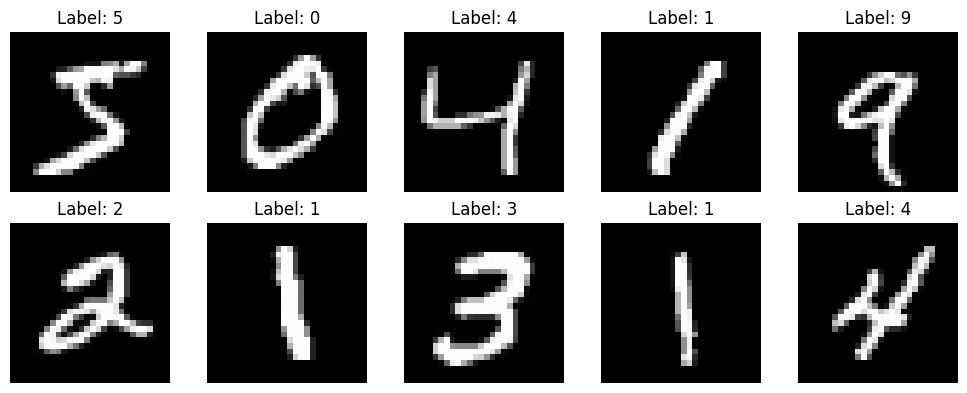

In [21]:
from torchvision import datasets, transforms
import torch
from matplotlib import pyplot as plt

# Using PyTorch's built in data for MNIST, we are telling it to download the training set
train_set = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())

# The data loader then specifies how we can load in the downloaded images into Python
dataloader = torch.utils.data.DataLoader(train_set, batch_size=10)

# Function to display images taken from https://pythonguides.com/pytorch-mnist/
def show_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()

    for i in range(10):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Now we will pull out 10 images to look at
images, labels = next(iter(dataloader))

# Show images
show_images(images, labels)

## Creating the Model Structure

PyTorch comes with several layers/operations that will be really helpful fo us to build our NN.

Model being leveraged: https://github.com/pytorch/examples/blob/main/mnist/main.py

* Conv2D: https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

  Allows the for creating a convolution layer. The layer needs a few pieces of information.
  1. How many channels are coming in. This usually refers to things like colors in normal RGB images (which would be 3 channels)
  2. How many output channels, which will essentially be the number of different filters we will learn
  3. The size of each filter
* Dropout: https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html

  Lets us randomly "ignore" certain neurons. This is helpful to reduce the chance that the neurons learn features that are too similar or overfit. This only takes place during training
* Linear: https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html

  Apply an affine linear transformation
* ReLu: https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html

  Activation function where the result is evaluated as the max(0, result from the neuron)
* Max Pooling: https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

  Provides a way to shrink the feature set into a smaller representation

* Log Soft Max: https://docs.pytorch.org/docs/2.8/generated/torch.nn.LogSoftmax.html
* Feature Visualization: https://kushmadlani.github.io/visualising-cnn-layers/

  

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # First convolution layer will have a single channel
        # the result will be 32 filters that will be learned
        # with each filter being a 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, 3, 1)

        # Second convolution layer that will take in the 32
        # filtered results and produce 64 filters with
        # each filter being a 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # One of the dropout operations we want to learn
        self.dropout1 = nn.Dropout(0.25)

        # A second dropout that is at a higher probability
        self.dropout2 = nn.Dropout(0.5)

        # First linear layer that will take 9216 features down to 128
        self.fc1 = nn.Linear(9216, 128)

        # Second linear layer that will take 128 features down to 10
        # This is very important because this represents the number 
        # of outputs (the digits 0 - 9)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First take the image and pass it through our first
        # convolution layer
        x = self.conv1(x)

        # Next apply the relu activation function
        x = F.relu(x)

        # Now pass the resulting filtered image through the
        # second convolution layer
        x = self.conv2(x)

        # Apply another relu activation function
        x = F.relu(x)

        # Down sample the resulting image following
        # a 2x2 max pool
        x = F.max_pool2d(x, 2)

        # Apply a drop out to reduce chance of 
        # over fitting
        x = self.dropout1(x)

        # We still have out data in a 2D format, but the output
        # is 1 dimensional (0 - 9). Flatten will make a single
        # dimensional input
        x = torch.flatten(x, 1)

        # Now that we have a 1D input, we can start to learn how to
        # turn our larger vector of features into a detection of
        # the digits 0-9
        x = self.fc1(x)

        # Use relu as the activation function again
        x = F.relu(x)

        # Apply the second drop out to again try to 
        # reduce the chance of overfitting
        x = self.dropout2(x)

        # The final linear layer that will bring down the features
        # to 10 in total
        x = self.fc2(x)

        # Finally we apply this log softmax
        # Soft max creates essentially a probabily 
        # distribution. We can think of it as "how likley is the input to be a given digit"
        output = F.log_softmax(x, dim=1)
        return output

## Training

We have now defined our model, the parameters will start with default values that are typically based on a probability function. So if we go back to our representation of the machine learning at this point we having the following.

* [x] Model: The Python class that inherets from PyTorch's neural network module 
* [x] Parameters: Initialized following probabiliy function, ready to be trained
* [ ] Loss Function: TBD
* [ ] Optimizer: TBD

### Understanding the Model Output

For this case, we are doing that is typically considered a "Classification" problem. We have some input, and we are trying to decide what "class" it belongs to (digits 0 - 9). The way we figure out what the model thinks the input is is by looking at the output tensor of our model. The output tensor dimension is a 1 dimensional tensor with 10 elements. We apply what is called the `log_softmax` to smooth out the output. Lets take the steps manually to get a sense of what the output is so we can understand what loss function will work for us.


In [38]:
# Lets start with some tensor to represent the output from the model before our softmax is applied
detection_results = torch.tensor([1.0, 250.0, 2.0, 300.0, 45.0, 6.0, 1.0, 2.5, 8.6, 10.0], dtype=torch.float32)

# Soft max results
torch.nn.functional.softmax(detection_results, dim=0)

tensor([0.0000e+00, 1.9287e-22, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [39]:
# Log Soft Max Results
torch.nn.functional.log_softmax(detection_results, dim=0)

tensor([-299.0000,  -50.0000, -298.0000,    0.0000, -255.0000, -294.0000,
        -299.0000, -297.5000, -291.4000, -290.0000])

### Loss Function

Since we are working with probability distributions, we can leverage the negative log-likelihood loss function. The negative log likelihood function essentially provides us a way to figure out how likely the output is based on the known distribution.

https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81/

### Optimizer

For the optimizer, we will use Adadelta. Adadelta is based on stochastic gradient descent, but the learning rate it self is updated as the learning takes place. This makes it a bit easier to train without having the guess-and-check the learning rate.

In [41]:
import torch.optim as optim

# Make sure our train and test sets are downloaded
train_data = datasets.MNIST(
    root='../data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root='../data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

# Setup the data loaders, we will load in 100 images per batch
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)

# The device is used for hardware acceleration, basically we can have the training run on the CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We now make an instance of our model, it will have default parameters
model = CustomCNN().to(device)

# Creating the optimizer, the initial learning rate we set fairly high, but it will adjust as the learning is run
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

# The train function itself, we have it as a function to make it easier to train for multiple "epoches".
# An "epoch" is a pass over all of the data. 
def train(epoch):
    # Put the model into train mode. This tells the model helpful things like if the parameters should
    # be fixed or if they are being trained on, also in train mode dropout layers actually apply
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We need the data to live on the same device as the model (either CPU or GPU)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Now we basically see what the output is for the given input
        output = model(data)

        # Calculate the loss based on the known value, remember our data loader includes
        # both the image and the known label
        loss = F.nll_loss(output, target)
        loss.backward()

        # Updated the optimizer
        optimizer.step()

        # Periodically (ever 100 batches) print some statistics. This isn't doing any ML work
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



# The test function is then used to determine
def test():
    # Put the model into eval mode. The parameters will be fixed and the dropout layers won't actually
    # do any drop out.
    model.eval()

    # These are some variables for us to capture statistics on model performance
    test_loss = 0
    correct = 0

    # No grad means no gradient, since we are evaluating and not training we don't need
    # to calculate the gradient. This is a memory saving step
    with torch.no_grad():
        for data, target in test_loader:
            # Just as before, reading in data and moving it to either the CPU or GPU
            data, target = data.to(device), target.to(device)

            # Running the image through the model
            output = model(data)

            # Compute the loss, this is so we can see how close to the answer we are
            test_loss += F.nll_loss(output, target).item()

            # Remember that the max value represents that the model things the answer is, 
            # so we can figure out what the prediction is
            pred = output.argmax(dim=1, keepdim=True)

            # We then can keep track of the number of correct answer
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Finally print out some statistics
    test_loss /= len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss: 0.4f}, Accuracy {correct}/{len(test_loader.dataset)}  ({100 * correct / len(test_loader.dataset):.0f}%)\n")

# We will run for 10 epoches, each time going through the whole dataset
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327783
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.378827
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.183052
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.101279
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.270541
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.118611

Test set: Average loss:  0.0006, Accuracy 9832/10000  (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.066137
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.098291
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.019800
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.068994
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.085877
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.077455

Test set: Average loss:  0.0004, Accuracy 9881/10000  (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.057500
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.065357
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.048075
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.070372
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.041086
Train Epoch: 3 [50000/60000 (83%)]	Loss: 

## After Training

### Saving the Model

Yay! We now have a trained model! Now what? Well first we probably don't want to have to train the model each time we want to use it. What we can do is save the output of the model.

Remember that a model is the structure and the parameters represent the specific solution learned. Therefore what we will need to do is save the parameters so we can load them again. PyTorch makes this pretty easy

In [47]:
# Save the model
torch.save(model.state_dict(), '../data/model.pth')

In [48]:
# Load the model
new_model = CustomCNN()
new_model.load_state_dict(torch.load('../data/model.pth'))

<All keys matched successfully>

In [49]:
# We can also see what the state dictionary is capturing
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([32, 1, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([128, 9216])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([10, 128])
fc2.bias 	 torch.Size([10])


### Using the Model

Great! But we've made this model so that we can actually use it. Lets take a very basic example and see how it performs on a set of images

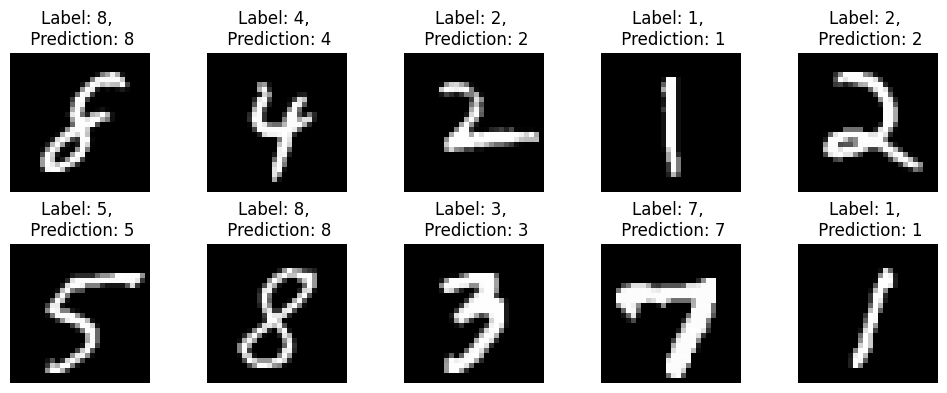

In [70]:
from torchvision import datasets, transforms
import torch
from matplotlib import pyplot as plt

# Using PyTorch's built in data for MNIST, we are telling it to download the training set
train_set = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())

# The data loader then specifies how we can load in the downloaded images into Python
dataloader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)

# Function to display images taken from https://pythonguides.com/pytorch-mnist/
def show_images(images, labels, pred):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()

    for i in range(10):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}, \n Prediction: {pred[i][0]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Now we will pull out 10 images to look at
images, labels = next(iter(dataloader))

# Lets now run the model on the images to get the predictions
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    pred = outputs.argmax(dim=1, keepdim=True).to('cpu')

# Show images
show_images(images, labels, pred)